In [1]:
!pip install gudhi

In [1]:
import numpy                 as np
import tensorflow            as tf
import matplotlib.pyplot     as plt
import pandas                as pd
import gudhi                 as gd
from tqdm                    import tqdm
from gudhi.tensorflow        import LowerStarSimplexTreeLayer, CubicalLayer, RipsLayer

In [2]:
# Load data from Excel file
df = pd.read_excel("preprocessed_data.xlsx", nrows=1000)

# Convert data to NumPy array
Xinit = df.iloc[:, :23].values.astype(np.float32)



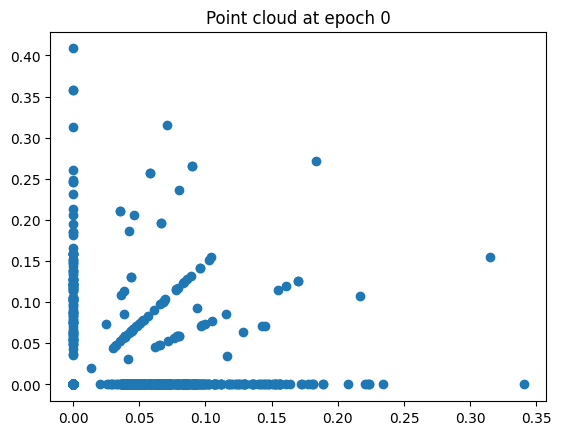

In [3]:
plt.figure()
plt.scatter(Xinit[:,0], Xinit[:,1])
plt.title('Point cloud at epoch 0')
plt.show()

In [4]:
st = gd.RipsComplex(points=Xinit, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

usetex mode requires TeX.


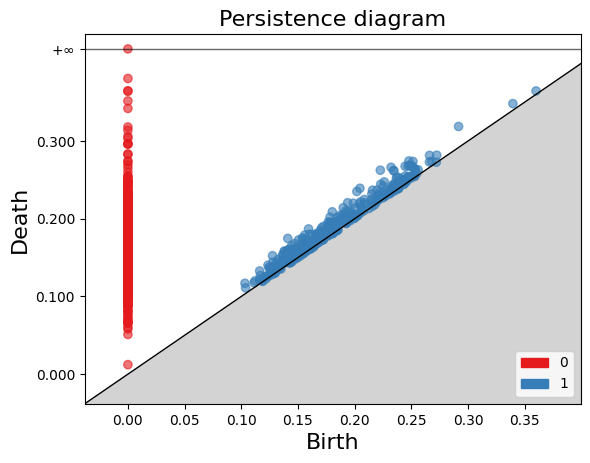

In [13]:
plot = gd.plot_persistence_diagram(dgm)

In [14]:
from gudhi import RipsComplex
# The parameters of the model are the point coordinates.

def _Rips(DX, max_edge, dimensions, homology_coeff_field):
    # Parameters: DX (distance matrix), 
    #             max_edge (maximum edge length for Rips filtration), 
    #             dimensions (homology dimensions)

    # Compute the persistence pairs with Gudhi
    rc = RipsComplex(distance_matrix=DX, max_edge_length=max_edge)
    st = rc.create_simplex_tree(max_dimension=max(dimensions)+1)
    st.compute_persistence(homology_coeff_field=homology_coeff_field)
    pairs = st.flag_persistence_generators()

    L_indices = []
    for dimension in dimensions:

        if dimension == 0:
            finite_pairs = pairs[0]
            essential_pairs = pairs[2]
        else:
            finite_pairs = pairs[1][dimension-1] if len(pairs[1]) >= dimension else np.empty(shape=[0,4])
            essential_pairs = pairs[3][dimension-1] if len(pairs[3]) >= dimension else np.empty(shape=[0,2])
        
        finite_indices = np.array(finite_pairs.flatten(), dtype=np.int32)
        essential_indices = np.array(essential_pairs.flatten(), dtype=np.int32)

        L_indices.append((finite_indices, essential_indices))

    return L_indices

class RipsLayer(tf.keras.layers.Layer):
    """
    TensorFlow layer for computing Rips persistence out of a point cloud
    """
    def __init__(self, homology_dimensions, maximum_edge_length=np.inf, min_persistence=None, homology_coeff_field=11, **kwargs):
        """
        Constructor for the RipsLayer class

        Parameters:
            maximum_edge_length (float): maximum edge length for the Rips complex 
            homology_dimensions (List[int]): list of homology dimensions
            min_persistence (List[float]): minimum distance-to-diagonal of the points in the output persistence diagrams (default None, in which case 0. is used for all dimensions)
            homology_coeff_field (int): homology field coefficient. Must be a prime number. Default value is 11. Max is 46337.
        """
        super().__init__(**kwargs)
        self.max_edge = maximum_edge_length
        self.dimensions = homology_dimensions
        self.min_persistence = min_persistence if min_persistence is not None else [0. for _ in range(len(self.dimensions))]
        self.hcf = homology_coeff_field
        assert len(self.min_persistence) == len(self.dimensions)

        
    def call(self, X):
        """
        Compute Rips persistence diagram associated to a point cloud

        Parameters:   
            X (TensorFlow variable): point cloud of shape [number of points, number of dimensions]

        Returns:
            List[Tuple[tf.Tensor,tf.Tensor]]: List of Rips persistence diagrams. The length of this list is the same than that of dimensions, i.e., there is one persistence diagram per homology dimension provided in the input list dimensions. Moreover, the finite and essential parts of the persistence diagrams are provided separately: each element of this list is a tuple of size two that contains the finite and essential parts of the corresponding persistence diagram, of shapes [num_finite_points, 2] and [num_essential_points, 1] respectively
        """    
        # Compute distance matrix
        DX = tf.norm(tf.expand_dims(X, 1)-tf.expand_dims(X, 0), axis=2)
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        indices = _Rips(DX.numpy(), self.max_edge, self.dimensions, self.hcf)
        # Get persistence diagrams by simply picking the corresponding entries in the distance matrix
        self.dgms = []
        for idx_dim, dimension in enumerate(self.dimensions):
            cur_idx = indices[idx_dim]
            if dimension > 0:
                finite_dgm = tf.reshape(tf.gather_nd(DX, tf.reshape(cur_idx[0], [-1,2])), [-1,2])
                essential_dgm = tf.reshape(tf.gather_nd(DX, tf.reshape(cur_idx[1], [-1,2])), [-1,1])
            else:
                reshaped_cur_idx = tf.reshape(cur_idx[0], [-1,3])
                finite_dgm = tf.concat([tf.zeros([reshaped_cur_idx.shape[0],1]), tf.reshape(tf.gather_nd(DX, reshaped_cur_idx[:,1:]), [-1,1])], axis=1)
                essential_dgm = tf.zeros([cur_idx[1].shape[0],1])
            min_pers = self.min_persistence[idx_dim]
            if min_pers >= 0:
                persistent_indices = tf.where(tf.math.abs(finite_dgm[:,1]-finite_dgm[:,0]) > min_pers)
                self.dgms.append((tf.reshape(tf.gather(finite_dgm, indices=persistent_indices),[-1,2]), essential_dgm))
            else:
                self.dgms.append((finite_dgm, essential_dgm))
        return self.dgms

In [15]:
X = tf.Variable(initial_value=Xinit, trainable=True)
layer = RipsLayer(maximum_edge_length=1., homology_dimensions=[1])

In [16]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)

In [17]:
losses, dgms = [], []
for epoch in tqdm(range(200+1)):
    
    with tf.GradientTape() as tape:
        dgm = layer.call(X)[0][0]
        # Opposite of the squared distances to the diagonal 
        persistence_loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0])))
        # Unit square regularization
        regularization = tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
        loss = persistence_loss + regularization
    gradients = tape.gradient(loss, [X])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

  5%|▍         | 10/201 [06:21<1:46:44, 33.53s/it]